## Prepare Notebook

In [17]:
from causalml.inference.meta import(
    BaseRClassifier,
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

Data set: [RetailHero.ai contest data:](https://ods.ai/competitions/x5-retailhero-uplift-modeling/data)

https://nbviewer.org/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero_EN.ipynb

In [18]:
from pathlib import Path

data_path = Path("/Users/juanitorduz/Downloads/retailhero-uplift/data")

clients_df = pd.read_csv(
    data_path / "clients.csv",
    parse_dates=["first_issue_date", "first_redeem_date"]
)
uplift_train_df = pd.read_csv(data_path / "uplift_train.csv")
uplift_test_df = pd.read_csv(data_path / "uplift_test.csv")

- `clients_df` data:

In [19]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400162 entries, 0 to 400161
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          400162 non-null  object        
 1   first_issue_date   400162 non-null  datetime64[ns]
 2   first_redeem_date  364693 non-null  datetime64[ns]
 3   age                400162 non-null  int64         
 4   gender             400162 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 15.3+ MB


- `uplift_train_df` data:

In [20]:
uplift_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   client_id      200039 non-null  object
 1   treatment_flg  200039 non-null  int64 
 2   target         200039 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


- `uplift_test_df` data:

In [21]:
uplift_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200123 entries, 0 to 200122
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   client_id  200123 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


## EDA

In [22]:
assert clients_df.shape[0] == clients_df["client_id"].nunique()
assert uplift_train_df.shape[0] == uplift_train_df["client_id"].nunique()
assert uplift_test_df.shape[0] == uplift_test_df["client_id"].nunique()

print(f"""
clients_id
----------
clients_df: {clients_df["client_id"].nunique()}
uplift_train_df: {uplift_train_df["client_id"].nunique()}
uplift_test_df: {uplift_test_df["client_id"].nunique()}
""")


clients_id
----------
clients_df: 400162
uplift_train_df: 200039
uplift_test_df: 200123



In [23]:
clients_df["gender"].value_counts()

U    185706
F    147649
M     66807
Name: gender, dtype: int64

In [24]:
clients_df["age"].value_counts()

 33      9437
 36      9394
 32      9354
 31      9286
 35      9152
         ... 
 537        1
-953        1
 1841       1
-2          1
 827        1
Name: age, Length: 290, dtype: int64

In [25]:
uplift_train_df \
    .groupby(["treatment_flg", "target"], as_index=False) \
    .agg(combination_count=("client_id", "count")) \
    .assign(
        total = lambda x: x["combination_count"].sum(),
        share = lambda x: x["combination_count"] / x["total"],
    )

,treatment_flg,target,combination_count,total,share
0,0,0,39695,200039,0.198436
1,0,1,60363,200039,0.301756
2,1,0,36342,200039,0.181675
3,1,1,63639,200039,0.318133


In [26]:
uplift_train_df \
    .groupby(["treatment_flg"], as_index=False) \
    .agg(combination_count=("client_id", "count")) \
    .assign(
        total = lambda x: x["combination_count"].sum(),
        share = lambda x: x["combination_count"] / x["total"],
    )

,treatment_flg,combination_count,total,share
0,0,100058,200039,0.500192
1,1,99981,200039,0.499808


## Prepare Data

In [27]:
features_df = clients_df.copy() \
    .set_index("client_id") \
    .assign(
        issue_redeem_delay_days = lambda x:
            (x["first_redeem_date"] - x["first_issue_date"]).dt.days
    ) \
    .drop(columns=["first_issue_date", "first_redeem_date"])


data_df = pd.merge(
    left=features_df,
    right=(
        uplift_train_df
        .copy()
        .set_index("client_id")
    ),
    left_index=True,
    right_index=True,
    how="inner"
)

In [28]:
from sklearn.model_selection import train_test_split

target_col = "target"
treatment_col = "treatment_flg"

y = data_df[target_col]
w = data_df[treatment_col]
x = data_df.drop(columns=[treatment_col, target_col])

idx_train, idx_val = train_test_split(
    data_df.index, test_size=0.3, random_state=123
)

x_train = x.loc[idx_train]
x_val = x.loc[idx_val]

w_train = w.loc[idx_train]
w_val = w.loc[idx_val]

y_train = y.loc[idx_train]
y_val = y.loc[idx_val]

In [29]:
preprocessor = ColumnTransformer(transformers=[
    ("issue_redeem_delay_days_imputer", SimpleImputer(fill_value=0), ["issue_redeem_delay_days"]),
    ("gender_ordinal_encoder", OrdinalEncoder(), ["gender"]),
], remainder='passthrough')

preprocessor.fit(x_train)
x_train_transformed = preprocessor.transform(x_train)
x_val_transformed =  preprocessor.transform(x_val)

## Models

### S-Learner

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer


xgb = XGBClassifier(use_label_encoder=False)

learner_s = BaseSClassifier(learner=xgb)

s_ate = learner_s.estimate_ate(X=x_train_transformed, treatment=w_train, y=y_train)

[22:26:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### T-Learner

In [31]:
learner_t = BaseTClassifier(learner=xgb)

t_ate_lwr, t_ate, t_ate_upr = learner_t.estimate_ate(X=x_train_transformed, treatment=w_train, y=y_train)

[22:26:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:26:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### X-Learner

In [32]:
from sklearn.linear_model import LinearRegression

learner_x = BaseXClassifier(
    outcome_learner=XGBClassifier(),
    effect_learner=LinearRegression(),
)

x_ate_lwr, x_ate, x_ate_upr = learner_x.estimate_ate(
    X=x_train_transformed,
    y=y_train,
    treatment=w_train,
    p=pd.Series(0.5, index=y_train.index)
)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:26:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:26:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [76]:
y_val_pred_s = learner_s.predict(X=x_val_transformed, treatment=w_val)
y_val_pred_t = learner_t.predict(X=x_val_transformed, treatment=w_val)

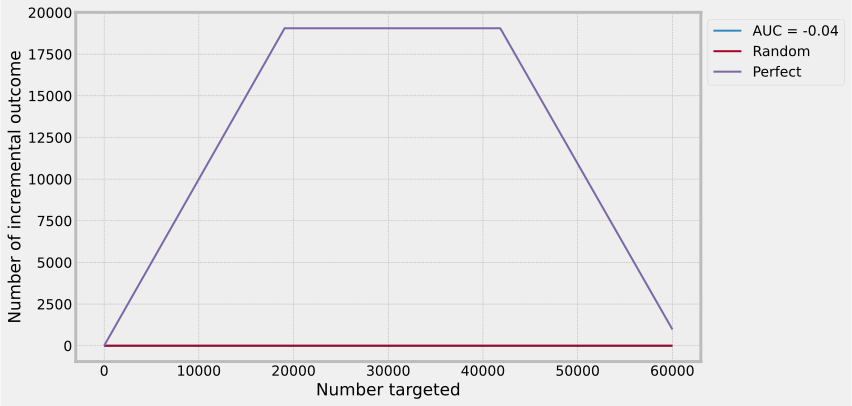

In [79]:
from sklift.viz import plot_qini_curve

fig, ax = plt.subplots()

plot_qini_curve(y_true=y_val, uplift=y_val_pred_t, treatment=w_val, perfect=True, ax=ax);